Development for The Dataland election predictions

Figure test.png saved in reports directory.


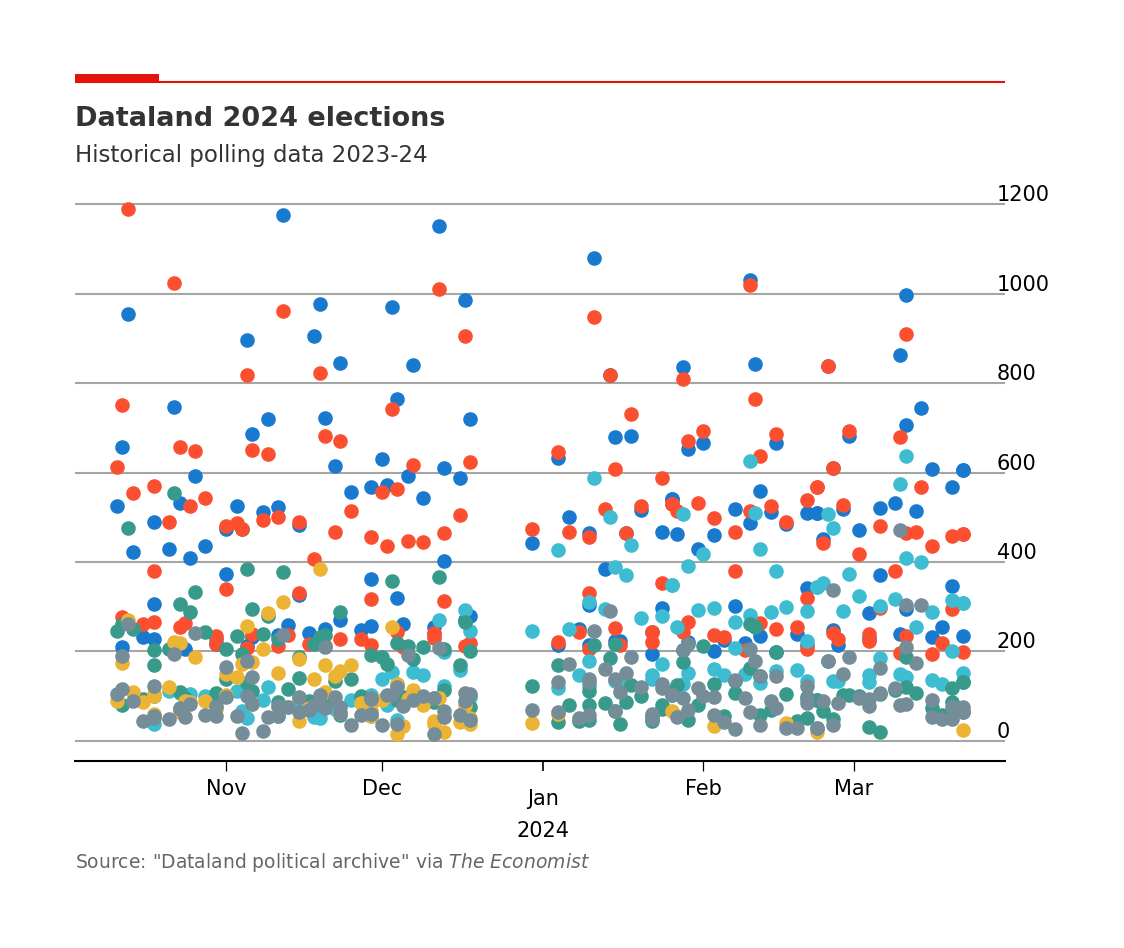

In [10]:
import sys
sys.path.append('..')

from src import DataEngineering, PlotTimeSeries
from matplotlib import pyplot as plt
import numpy as np

df = DataEngineering().load_from_file()
plt_ts = PlotTimeSeries()
fig, ax = plt_ts.get_panels()

for i in ['Bulstrode', 'Lydgate', 'Vincy', 'Casaubon', 'Chettam', 'Others']:

    ax.scatter(df['Date'], df[i] * df['Sample'])
    


plt_ts.set_title('Dataland 2024 elections', subtitle='Historical polling data 2023-24')
plt_ts.set_source('Dataland political archive', pad=0.15)

# fig.set_facecolor('lightgrey')
plt_ts.savefig('test.png', dpi=250)

Train dates : 2023-10-12 00:00:00 --- 2024-03-22 00:00:00  (n=110)
Test dates  : 2023-10-11 00:00:00 --- 2024-03-22 00:00:00  (n=36)


C:\Users\edoar\AppData\Local\Temp\ipykernel_20996\1626926129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.sort_values(['Date'], ignore_index=True, inplace=True)
C:\Users\edoar\AppData\Local\Temp\ipykernel_20996\1626926129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.sort_values(['Date'], ignore_index=True, inplace=True)


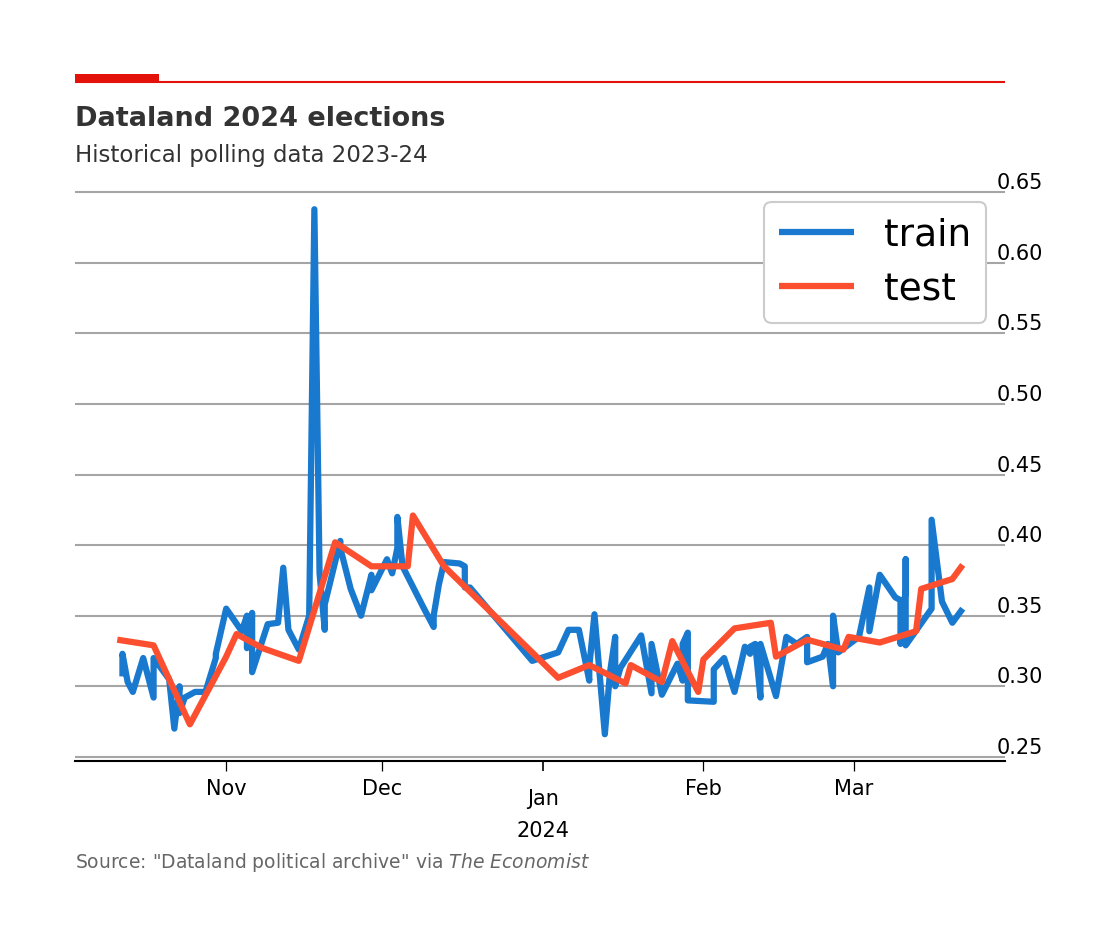

In [15]:
# Split data into train-test
# ==============================================================================
steps = int(0.25 * len(df))
data_train = df[:-steps]
data_test  = df[-steps:]


data_train.sort_values(['Date'], ignore_index=True, inplace=True)
data_train.reset_index(drop=True, inplace=True)
    

data_test.sort_values(['Date'], ignore_index=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)
    
print(f"Train dates : {data_train['Date'].min()} --- {data_train['Date'].max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test['Date'].min()} --- {data_test['Date'].max()}  (n={len(data_test)})")

plt_ts = PlotTimeSeries()
fig, ax = plt_ts.get_panels()
plt_ts.set_title('Dataland 2024 elections', subtitle='Historical polling data 2023-24')
plt_ts.set_source('Dataland political archive', pad=0.15)

ax.plot(data_train['Date'], data_train['Bulstrode'], label='train')
ax.plot(data_test['Date'], data_test['Bulstrode'], label='test')
ax.legend()

In [16]:
# Modeling and Forecasting
# ==============================================================================
from darts import TimeSeries

In [17]:
series = TimeSeries.from_dataframe(df, time_col='Date', freq=1, value_cols=['Bulstrode', 'Lydgate', 'Vincy', 'Casaubon', 'Chettam', 'Others'])
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

ValueError: Invalid frequency: 1